# Practical Project - Business Process Management
### Enrico Lanza - 1603096

The aim of this project is to predict the remaining time of an application process. For this purpose, we use the BPI Challenge 2018 dataset, which describes applications for EU direct payments for German farmers from the European Agricultural Guarantee Fund. We assume that the last event of an application is the end of the process and is therefore considered as remaining time = 0. 

To achieve this, our first idea is to predict the remaining time of the process for each individual event using normal regression. In the following, we will first analyze the data and then use simple regression in the form of a neural network and a tree-based algorithm for our prediction.


In [112]:
# First we will load the packages we need 
from BPM_utils import load_packages
load_packages()

Packages loaded successfully


In [113]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Related third party imports
import pm4py
import holidays
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from keras.models import load_model

# Local application/library specific imports
from BPM_utils import tune_NN_model_optuna
from BPM_utils import tune_XGB_model

# 1. Preparation

The data we are going to use comes from the BPI challenge 2018, for resource reasons we have not included the file in this project. If you want to use it, you can download it from:
https://data.4tu.nl/articles/dataset/BPI_Challenge_2018/12688355/1

van Dongen, Boudewijn; Borchert, F. (Florian) (2018): BPI Challenge 2018. Version 1. 4TU.ResearchData. dataset. https://doi.org/10.4121/uuid:3301445f-95e8-4ff0-98a4-901f1f204972

In [114]:
"""
#Load the data from the xes file and convert it to a dataframe (10 minutes)
path = 'BPI Challenge 2018.xes'
data_xes = pm4py.read_xes(path)    
data = pm4py.convert_to_dataframe(data_xes)
data.to_csv('BPI 2018.csv', index=False)
"""

"\n#Load the data from the xes file and convert it to a dataframe (10 minutes)\npath = 'BPI Challenge 2018.xes'\ndata_xes = pm4py.read_xes(path)    \ndata = pm4py.convert_to_dataframe(data_xes)\ndata.to_csv('BPI 2018.csv', index=False)\n"

This code outputs an example path for an application. Since we will not use paths for the first part, we will simply convert the file into a data frame.

In [115]:
"""
# Examine a specific trace
example_trace = data_xes[0]  # Taking the first trace for demonstration
for i in range(len(example_trace)-1):
    current_event = example_trace[i]
    next_event = example_trace[i+1]
    print(f"Current Event: {current_event['concept:name']}, Next Event: {next_event['concept:name']}")
"""

'\n# Examine a specific trace\nexample_trace = data_xes[0]  # Taking the first trace for demonstration\nfor i in range(len(example_trace)-1):\n    current_event = example_trace[i]\n    next_event = example_trace[i+1]\n    print(f"Current Event: {current_event[\'concept:name\']}, Next Event: {next_event[\'concept:name\']}")\n'

In [116]:
# Read the data from the csv file
data = pd.read_csv('BPI 2018.csv')

# Display column names
print("Column names:")
print(data.columns)

Column names:
Index(['success', 'org:resource', 'docid_uuid', 'doctype', 'subprocess',
       'docid', 'activity', 'note', 'eventid', 'identity:id', 'concept:name',
       'lifecycle:transition', 'time:timestamp', 'case:young farmer',
       'case:selected_random', 'case:penalty_AJLP', 'case:application',
       'case:penalty_amount0', 'case:program-id', 'case:penalty_BGKV',
       'case:penalty_AUVP', 'case:applicant', 'case:risk_factor',
       'case:small farmer', 'case:penalty_BGP', 'case:department',
       'case:penalty_C16', 'case:penalty_BGK', 'case:penalty_AVUVP',
       'case:penalty_CC', 'case:penalty_AVJLP', 'case:penalty_C9',
       'case:cross_compliance', 'case:rejected', 'case:greening',
       'case:penalty_C4', 'case:penalty_AVGP', 'case:penalty_ABP',
       'case:penalty_B6', 'case:penalty_B4', 'case:penalty_B5',
       'case:penalty_AVBP', 'case:penalty_B2', 'case:selected_risk',
       'case:penalty_B3', 'case:area', 'case:selected_manually',
       'case:penalty_A

# 1.1 Preparation of timestamp

The main information we need for this task is the timestamp. Therfore we convert the column with this data to datatime. We will also include following resulting information:

- date : date of timestamp
- time : time of timestamp
- weekday: which weekday is the timestamp from (Monday=0, Tuesday=1, ..., Sunday=6)
- is_holiday: is this day a federal holiday in germany (boolean)

To execute the task we will need information about the remaining time of the application process. Therfor we will search for the latest event of each application and mark it with

- is_latest : boolean which is TRUE if it is the latest event of an application process
- remaining_time : time to the latest event in the process (in seconds)

In [117]:

# Identify rows where the timestamp column has the default value
default_timestamp = '1970-01-01T01:00:00+01:00'
mask = data['time:timestamp'] == default_timestamp
print("Number of rows with default timestamp: ", mask.sum())

# Convert the timestamp column to datetime
def convert_timestamp(ts):
    try:
        return pd.to_datetime(ts, format='%Y-%m-%d %H:%M:%S.%f%z')
    except ValueError:
        return pd.to_datetime(ts, format='%Y-%m-%d %H:%M:%S%z')
data['time:timestamp'] = data['time:timestamp'].apply(convert_timestamp)
data['time:timestamp'].describe()


Number of rows with default timestamp:  0


count                                2514266
mean     2016-10-21 20:53:28.748489216+00:00
min                2014-05-04 00:00:00+00:00
25%      2015-12-03 18:34:53.008500224+00:00
50%      2016-11-17 15:27:38.019500032+00:00
75%      2017-08-07 15:34:02.551000064+00:00
max                2018-01-19 13:03:02+00:00
Name: time:timestamp, dtype: object

In [118]:
# Sort the DataFrame by 'time:timestamp' and 'case:application'
data = data.sort_values(['case:application', 'time:timestamp'])

# Create a new column 'is_latest' that is True for the latest event of each application
data['is_latest'] = data.groupby('case:application')['time:timestamp'].transform(lambda x: x == x.max())

# Create a new column 'latest_time' that contains the timestamp of the latest event for each application
data['latest_time'] = data.groupby('case:application')['time:timestamp'].transform(max)

# Create a new column 'remaining_time' that contains the time from each event to the latest event of its application
data['remaining_time'] = data['latest_time'] - data['time:timestamp']

# Convert 'remaining_time' to seconds
data['remaining_time'] = data['remaining_time'].dt.total_seconds()

# Drop the 'latest_time' column
data = data.drop(columns=['latest_time'])

C:\Users\lanza\AppData\Local\Temp\ipykernel_24200\547872076.py:8: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data['latest_time'] = data.groupby('case:application')['time:timestamp'].transform(max)


In [119]:
german_holidays = holidays.Germany()

# Create a new column for the date (without time)
data['date'] = data['time:timestamp'].dt.date

# Create a new column 'time' that contains the time part of each timestamp
data['time'] = data['time:timestamp'].dt.time

# Create a new column 'weekday' that contains the day of the week
data['weekday'] = data['time:timestamp'].dt.day_name()

# Create a new column 'is_holiday' that indicates whether each date is a holiday
data['is_holiday'] = data['date'].apply(lambda x: x in german_holidays)

# Create a new column 'month' that contains the month of the year
data['month'] = data['time:timestamp'].dt.month

# Create a new column 'year' that contains the year
data['year'] = data['time:timestamp'].dt.year

# Create a new column 'day' that contains the day
data['day'] = data['time:timestamp'].dt.day

For the purpose of this task we will only watch at the events that are complete. For this project, a complete application is one that finishes with a payment. All other applications will be droped. We decided to drop all application that were not completed succefull (abortion or some kind of error) since this should be an exeption and we try to give a remaining time prediction for a normal applicant.

Now we will drop all applications where the last event is not of activity "finish payment".

In [120]:
# Get the number of unique applications before the drop
num_apps_before = data['case:application'].nunique()

# Get applications where the last event is not 'finish payment'
apps_not_finish_payment = data[(data['is_latest'] == 1) & (data['activity'] != 'finish payment')]['case:application']

# Drop the events of these applications
data = data[~data['case:application'].isin(apps_not_finish_payment)]

# Get the number of unique applications after the drop
num_apps_after = data['case:application'].nunique()

# Calculate the percentage of applications dropped
percent_dropped = (num_apps_before - num_apps_after) / num_apps_before * 100

print(f'{percent_dropped}% of applications were dropped.')

20.49578853660207% of applications were dropped.


## 1.2 Visualization of Data

First we want to see the events per day over the whold dataset

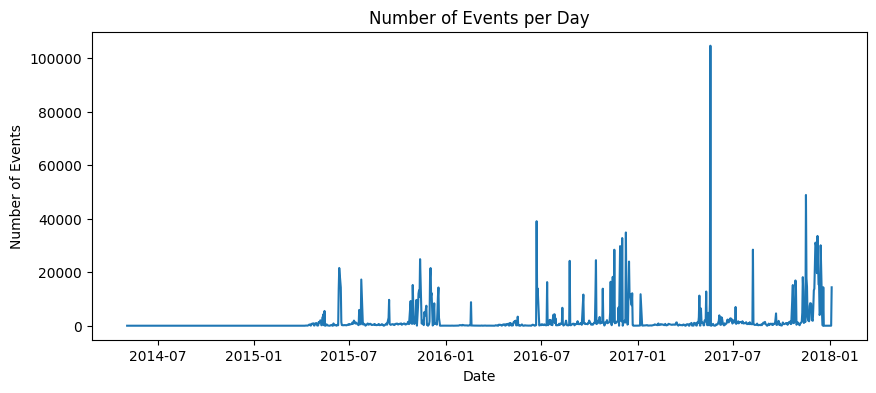

In [121]:
# Count the number of events for each day
events_per_day = data.groupby('date').size()

# Plot the number of events per day
events_per_day.plot(kind='line', figsize=(10,4))
plt.title('Number of Events per Day')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()

We seem to see that there are some periodic trends within our dataset

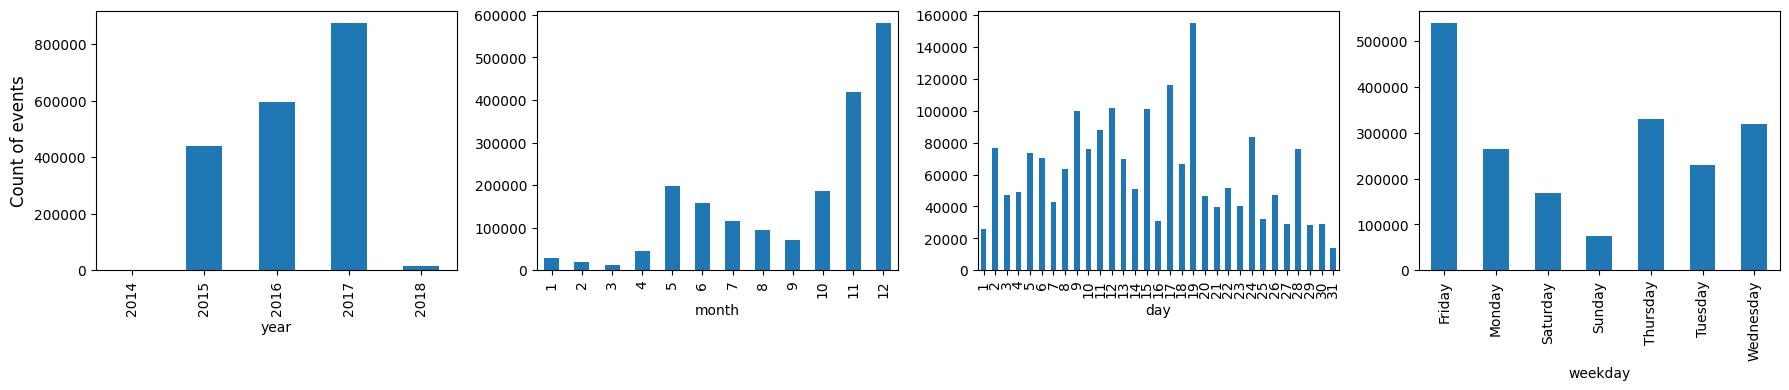

In [122]:
fs = 12
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

# Order the weekdays
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for col, col_name in enumerate(['year', 'month', 'day', 'weekday']):
    data.groupby(col_name).size().plot(kind='bar', ax=axes[col], legend=False)
    
axes[0].set_ylabel('Count of events', fontsize=fs)

fig.tight_layout()
plt.show()

As expected, on weekends significantly less events are processed. Also if there is holidays, nearly no events are processed. This confirms the assumption that weekends are significant for this dataset.

What is also interesting to see ist that most events seem to happen at the end of each year. This makes sense if we assume that the payment to the farmer is on a yearly basis and the farmers tend to apply at the end of the year. We also have an increase in the middle of the year, it seems like some applications may be on a half-year basis. 



# Preprocessing for ML

In [123]:
data['time:timestamp'] = pd.to_datetime(data['time:timestamp']).astype('int64') / 10**9
data['time'] = data['time'].apply(lambda t: t.hour*3600 + t.minute*60 + t.second)

# Iterate over each column
for column in data.columns:
    # Check if the column is non-numerical and has less than 50 unique values
    if data[column].dtype == 'object' and data[column].nunique() < 50:
        # One-hot encode the column and drop the original column
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data.drop([column], axis=1, inplace=True)
    else:
        # Factorize the column
        data[column] = pd.factorize(data[column])[0]

# Print the new data types of the columns
print(data.dtypes)

success              int64
org:resource         int64
docid_uuid           int64
docid                int64
eventid              int64
                     ...  
weekday_Saturday      bool
weekday_Sunday        bool
weekday_Thursday      bool
weekday_Tuesday       bool
weekday_Wednesday     bool
Length: 201, dtype: object


In [124]:
# Translate all boolean columns to integers
for col in data.columns:
    if data[col].dtype == 'bool':
        data[col] = data[col].astype(int)

# Selection of Features

<Axes: >

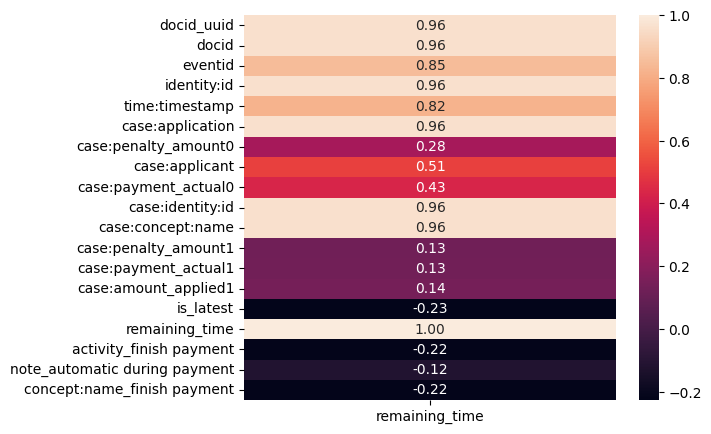

In [125]:
import numpy as np
import seaborn as sns

# Calculate correlation
corr = data.corr()

# Set correlation threshold
threshold = 0.1

# Select only correlations for "remaining_time"
corr_remaining_time = corr['remaining_time']

# Create a mask for values above the threshold
mask = np.abs(corr_remaining_time) > threshold

# Apply the mask to the correlations
significant_corr_remaining_time = corr_remaining_time[mask]

# Remove NaN values
significant_corr_remaining_time.dropna(inplace=True)

# Convert Series to DataFrame for heatmap compatibility
significant_corr_remaining_time = significant_corr_remaining_time.to_frame()

# Plot the heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(significant_corr_remaining_time, annot=True, annot_kws={'fontsize': 10}, fmt='.2f', ax=ax)

Here we try to see the significance between remaining_time and other features. Due to the amount of features we filter with a threshold (0.1) and only show the significance between remaining_time and features.

Remarkable is that there are multiple significant correlations between the remaining time and penalties. Not suprisingly there is also a correlation between actual payment and remaining_time, since when the payment happens this indicates that the process goes to an end. As already seen earlier there is a high correlation between year and remeining time since it seems like many applications are processed at the end of the year. 

# 2. Predictions

First of all we split into train, val and test set.

In [126]:
from sklearn.model_selection import train_test_split

# Get a list of unique applications
applications = data['case:application'].unique()

# Split the applications into train, validation, and test sets
train_apps, test_apps = train_test_split(applications, test_size=0.2, random_state=42)
train_apps, val_apps = train_test_split(train_apps, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Use the lists of applications to split the data into train, validation, and test sets
train_data = data[data['case:application'].isin(train_apps)]
val_data = data[data['case:application'].isin(val_apps)]
test_data = data[data['case:application'].isin(test_apps)]

In [127]:
import pickle

with open('train_val_test.pkl', 'wb') as f:
    pickle.dump((train_data, val_data, test_data), f)

### 2.1 Prediction with Keras

Now we will try to predict the remaining time (and the chance that an event is the latest) of an event with a simple Keras Regressor that we optimize with Optuna.

In [128]:
import pickle
with open('train_val_test.pkl', 'rb') as f:
    train_data, val_data, test_data = pickle.load(f)

# Define the features and target
X_train = np.array(train_data.drop(columns=['remaining_time']))
y_train = np.array(train_data['remaining_time'])
X_val = np.array(val_data.drop(columns=['remaining_time']))
y_val = np.array(val_data['remaining_time'])
X_test = np.array(test_data.drop(columns=['remaining_time']))
y_test = np.array(test_data['remaining_time'])

In [129]:
#ann_model, ann_params, status = tune_NN_model_optuna(X_train, y_train, X_val, y_val)
#ann_model.save('ann_model.h5') 

In [130]:
ann_model = load_model('ann_model_v1.h5')
ann_prediction = ann_model.predict(X_test)

ValueError: in user code:

    File "c:\Users\lanza\Integrated-vs-Seperated-Master-Thesis\.venv\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\lanza\Integrated-vs-Seperated-Master-Thesis\.venv\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\lanza\Integrated-vs-Seperated-Master-Thesis\.venv\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\lanza\Integrated-vs-Seperated-Master-Thesis\.venv\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\lanza\Integrated-vs-Seperated-Master-Thesis\.venv\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\lanza\Integrated-vs-Seperated-Master-Thesis\.venv\Lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 69), found shape=(None, 200)


### 2.2 Prediction with XGBoost



In [ ]:
#xgb_model, xgb_params, status = tune_XGB_model(X_train, y_train, X_val, y_val)
#xgb_model.save_model('xgb_model.json')

In [ ]:
import xgboost as xgb
xgb_model = xgb.Booster()
xgb_model.load_model('xgb_model_v1.json')

xgb_prediction = xgb_model.predict(xgb.DMatrix(X_test))

# 3. Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming you have the true labels in y_test and your predictions in xgb_prediction and ann_prediction
xgb_mse = mean_squared_error(y_test, xgb_prediction)
ann_mse = mean_squared_error(y_test, ann_prediction)

xgb_rmse = np.sqrt(xgb_mse)
ann_rmse = np.sqrt(ann_mse)

xgb_mae = mean_absolute_error(y_test, xgb_prediction)
ann_mae = mean_absolute_error(y_test, ann_prediction)

xgb_r2 = r2_score(y_test, xgb_prediction)
ann_r2 = r2_score(y_test, ann_prediction)

print("XGBoost Metrics:")
print(f"MSE: {xgb_mse}, RMSE: {xgb_rmse}, MAE: {xgb_mae}, R2 Score: {xgb_r2}")

print("\nANN Metrics:")
print(f"MSE: {ann_mse}, RMSE: {ann_rmse}, MAE: {ann_mae}, R2 Score: {ann_r2}")

XGBoost Metrics:
MSE: 38874952649287.05, RMSE: 6234978.159487573, MAE: 3019284.65707803, R2 Score: -38199930610.68467

ANN Metrics:
MSE: 102151769871548.7, RMSE: 10107015.873716075, MAE: 5148115.749364699, R2 Score: -5.742610578427852


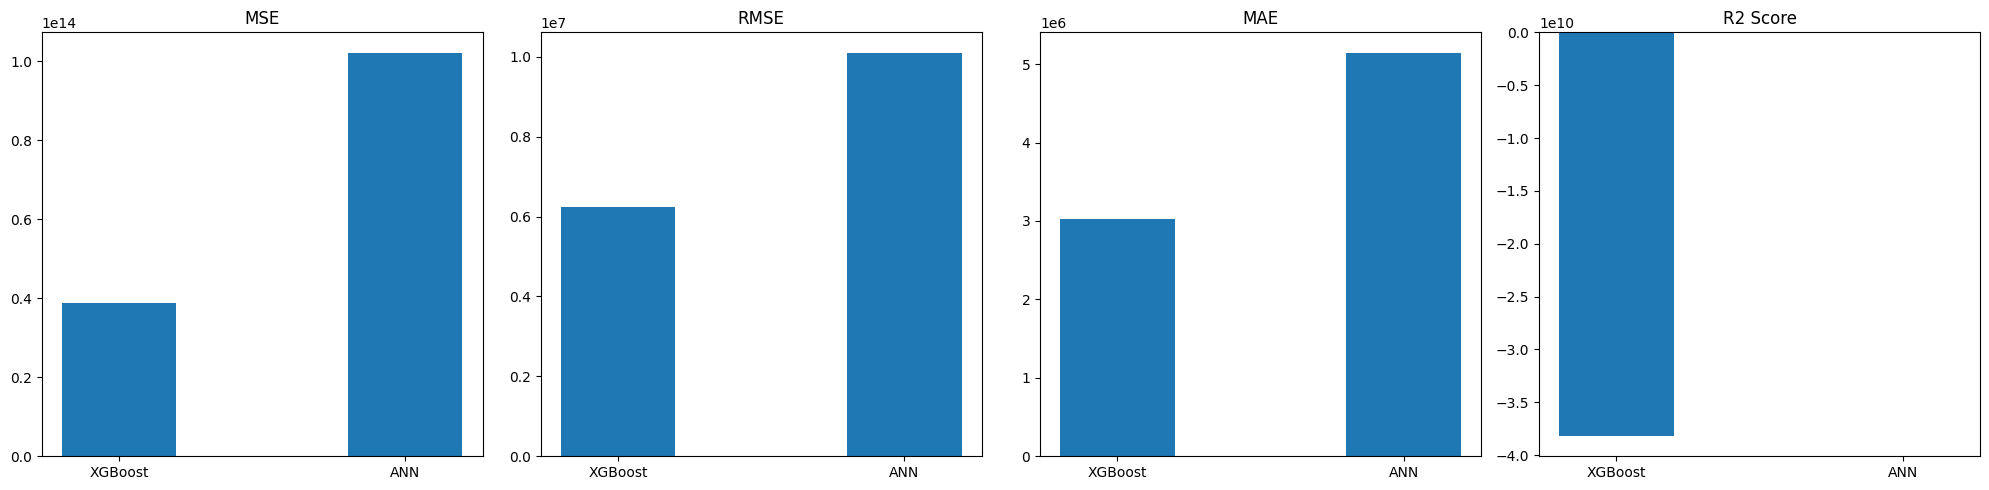

In [ ]:
import matplotlib.pyplot as plt

# Metrics
metrics = ['MSE', 'RMSE', 'MAE', 'R2 Score']

# XGBoost values
xgb_values = [xgb_mse, xgb_rmse, xgb_mae, xgb_r2]

# ANN values
ann_values = [ann_mse, ann_rmse, ann_mae, ann_r2]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Loop through each metric and plot
for i, metric in enumerate(metrics):
    axs[i].bar(['XGBoost', 'ANN'], [xgb_values[i], ann_values[i]], width=0.4)
    axs[i].set_title(metric)

# Display the plot
plt.tight_layout()
plt.show()

# 4. Usining Sequence Data

Obviously, our previous approach does not exploit the full potential of the data as it does not utilize the information about the paths.

As shown in the lecture and the literature (Verenich et al.), LSTM seems to be the most promising approach. So our next approach is to use LSTM and compare the results with our previous approach. By doing so, we want to see how much our prediction improves.

@article{Verenich et al.,
author = {Verenich, Ilya and Dumas, Marlon and La Rosa, Marcello and Maggi, Fabrizio and Teinemaa, Irene},
year = {2019},
month = {07},
pages = {1-34},
title = {Survey and Cross-benchmark Comparison of Remaining Time Prediction Methods in Business Process Monitoring},
volume = {10},
journal = {ACM Transactions on Intelligent Systems and Technology},
doi = {10.1145/3331449}
}